# Finding Maxima and Minima of DiffEq Solutions
https://tutorials.juliadiffeq.org/html/ode_extras/03-ode_minmax.html

In this tutorial we will show how to use Optim.jl to find the maxima and minima of solutions. Let's take a look at the double pendulum:

In [1]:
#Constants and setup
using OrdinaryDiffEq
using NLopt, ForwardDiff
using Optim
using Plots
gr()

Plots.GRBackend()

In [9]:
initial = [0.01, 0.01, 0.01, 0.01]
tspan = (0.,100.)

#Define the problem
function double_pendulum_hamiltonian(udot,u,p,t)
    α  = u[1]
    lα = u[2]
    β  = u[3]
    lβ = u[4]
    udot .=
    [2(lα-(1+cos(β))lβ)/(3-cos(2β)),
    -2sin(α) - sin(α+β),
    2(-(1+cos(β))lα + (3+2cos(β))lβ)/(3-cos(2β)),
    -sin(α+β) - 2sin(β)*(((lα-lβ)lβ)/(3-cos(2β))) + 2sin(2β)*((lα^2 - 2(1+cos(β))lα*lβ + (3+2cos(β))lβ^2)/(3-cos(2β))^2)]
end

#Pass to solvers
poincare = ODEProblem(double_pendulum_hamiltonian, initial, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.01, 0.01, 0.01, 0.01]

In [10]:
sol = solve(poincare, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 193-element Array{Float64,1}:
   0.0                
   0.08332584852065579
   0.24175300587841853
   0.4389533535703127 
   0.6797301355043014 
   0.9647629621490508 
   1.3179425637594349 
   1.7031226016307728 
   2.0678503967116617 
   2.4717899847517866 
   2.90745854114804   
   3.4330782386631786 
   3.881988354121059  
   ⋮                  
  94.2423774460387    
  94.76894022012044   
  95.31885567745671   
  95.8457309586563    
  96.3577910122243    
  96.92913461915474   
  97.44679415429573   
  97.96248479179103   
  98.51183391850897   
  99.0608253308051    
  99.58284388126884   
 100.0                
u: 193-element Array{Array{Float64,1},1}:
 [0.01, 0.01, 0.01, 0.01]                                                                    
 [0.00917068738040534, 0.0066690004553842845, 0.012420525490765832, 0.008266408515192912]    
 [0.007673275265972518, 0.00037461737897660346, 0.01644259022773

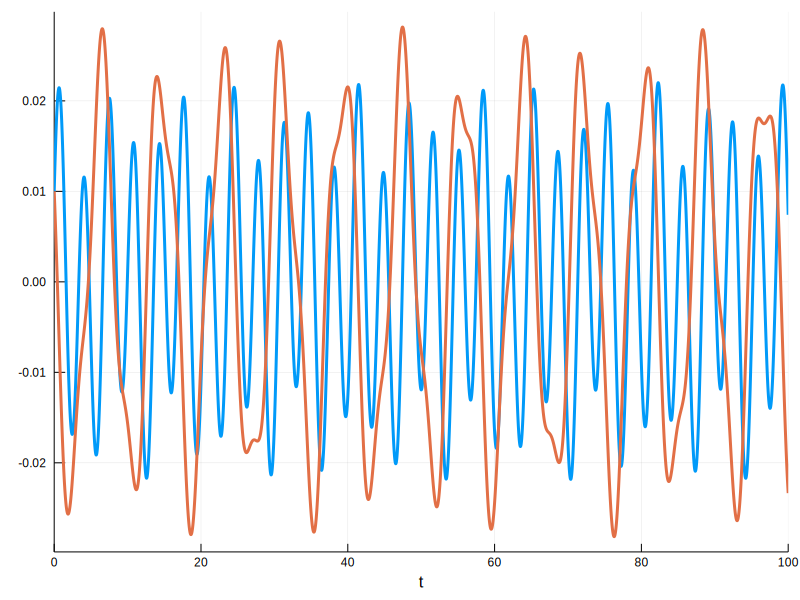

In [11]:
plot(sol, vars=[(0,3),(0,4)], leg=false, plotdensity=10000)
plot!(size=(800,600))
# savefig("maxima_minima_diffeq_solutions_01.png")

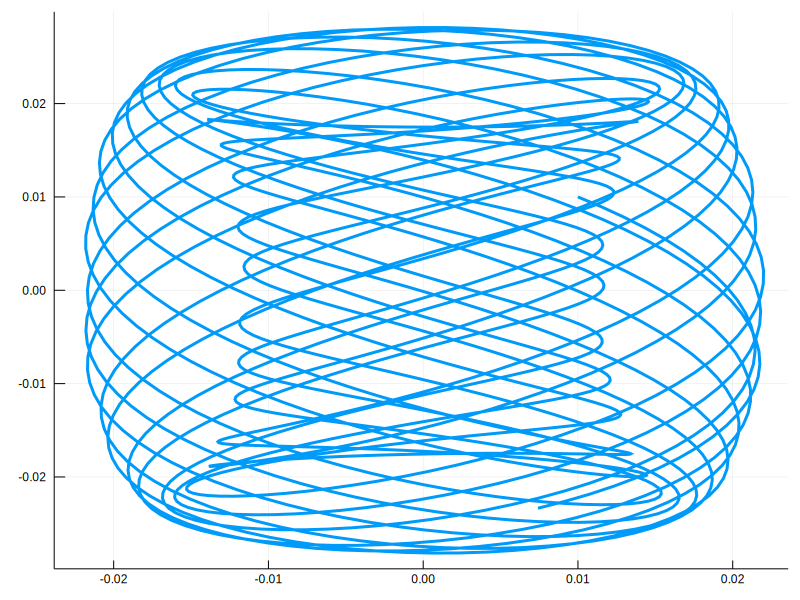

In [12]:
plot(sol, vars=(3,4), leg=false)
plot!(size=(800,600))

# Local Optimization
Let's fine out what some of the local maxima and minima are. Optim.jl can be used to minimize functions, and the solution type has a continuous interpolation which can be used. Let's look for the local optima for the 4th variable around t=20. Thus our optimization function is:

In [13]:
f = (t) -> sol(t,idxs=4)

#9 (generic function with 1 method)

first(t) is the same as t[1] which transforms the array of size 1 into a number. idxs=4 is the same as sol(first(t))[4] but does the calculation without a temporary array and thus is faster. To find a local minima, we can simply call Optim on this function. Let's find a local minimum:

In [14]:
opt = optimize(f,18.0,22.0)

MethodError: MethodError: no method matching optimize(::var"#9#10", ::Float64, ::Float64)

From this printout we see that the minimum is at t=18.63 and the value is -2.79e-2. We can get these in code-form via:

In [23]:
println(opt.minimizer)

18.63212745185752


In [24]:
println(opt.minimum)

-0.027931635651544703


To get the maximum, we just minimize the negative of the function:

In [25]:
f = (t) -> -sol(first(t),idxs=4)
opt2 = optimize(f,0.0,22.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 22.000000]
 * Minimizer: 1.399975e+01
 * Minimum: -2.269411e-02
 * Iterations: 13
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 14

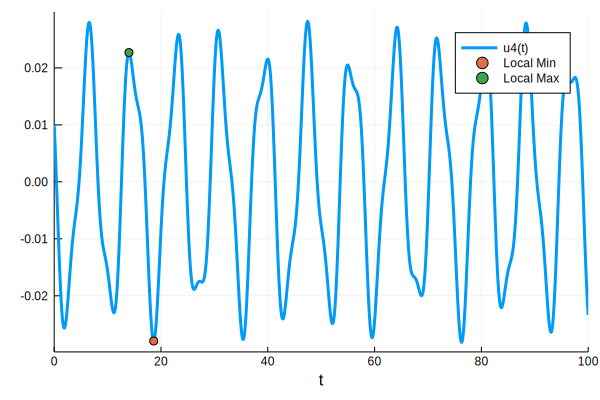

In [26]:
plot(sol, vars=(0,4), plotdensity=10000)
scatter!([opt.minimizer],[opt.minimum],label="Local Min")
scatter!([opt2.minimizer],[-opt2.minimum],label="Local Max")

Brent's method will locally minimize over the full interval. If we instead want a local maxima nearest to a point, we can use BFGS(). In this case, we need to optimize a vector [t], and thus dereference it to a number using first(t).

In [27]:
f = (t) -> -sol(first(t),idxs=4)
opt = optimize(f,[20.0],BFGS())

 * Status: success

 * Candidate solution
    Minimizer: [2.33e+01]
    Minimum:   -2.588588e-02

 * Found with
    Algorithm:     BFGS
    Initial Point: [2.00e+01]

 * Convergence measures
    |x - x'|               = 1.11e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.78e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.68e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.49e-09 ≰ 0.0e+00
    |g(x)|                 = 8.41e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    16
    ∇f(x) calls:   16


# Global Optimization
If we instead want to find global maxima and minima, we need to look somewhere else. For this there are many choices. A pure Julia option is BlackBoxOptim.jl, but I will use NLopt.jl. Following the NLopt.jl tutorial but replacing their function with out own:

In [28]:
count = 0 # keep track of # function evaluations

function g(t::Vector, grad::Vector)
  if length(grad) > 0
    #use ForwardDiff for the gradients
    grad[1] = ForwardDiff.derivative((t)->sol(first(t),idxs=4),t)
  end
  sol(first(t),idxs=4)
end
opt = NLopt.Opt(:GN_ORIG_DIRECT_L, 1)
NLopt.lower_bounds!(opt, [0.0])
NLopt.upper_bounds!(opt, [40.0])
NLopt.xtol_rel!(opt,1e-8)
NLopt.min_objective!(opt, g)
(minf,minx,ret) = NLopt.optimize(opt,[20.0])
println(minf," ",minx," ",ret)

-0.02793163565154469 [18.63212748151789] XTOL_REACHED


In [29]:
NLopt.max_objective!(opt, g)
(maxf,maxx,ret) = NLopt.optimize(opt,[20.0])
println(maxf," ",maxx," ",ret)

0.0279685724990733 [6.553695770075807] XTOL_REACHED


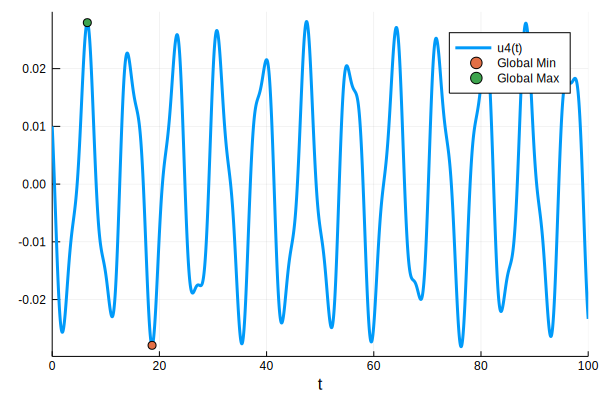

In [30]:
plot(sol, vars=(0,4), plotdensity=10000)
scatter!([minx],[minf],label="Global Min")
scatter!([maxx],[maxf],label="Global Max")